# !module list

In [33]:
!pip install tensorflow_hub

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 108 kB 2.7 MB/s            


In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pickle
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import time
import shutil
import requests
import tarfile
import glob

import argparse
from tokenize import tokenize, untokenize, COMMENT, STRING, NEWLINE, ENCODING, ENDMARKER, NL, INDENT, NUMBER
from io import BytesIO
import json

import pandas as pd
import numpy as np
import string, os
tf.__version__

'2.4.0'

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
file_name = "Project_CodeNet_LangClass.tar.gz"
data_url = f"https://dax-cdn.cdn.appdomain.cloud/dax-project-codenet/1.0.0/{file_name}"

# Download tar archive to local disk
with open(file_name, "wb") as f:
    f.write(requests.get(data_url).content)
    
# Extract contents of archive to local disk
if os.path.exists("data"):
    shutil.rmtree("data")    
with tarfile.open(file_name) as tfile:
    tfile.extractall()

In [4]:
lits = json.load(open("literals.json"))

def process_string(token, special_chars={" ": "U+0020", ",": "U+002C"}):
    str_quote_options = ["'''", '"""', "'", '"']
    start_quote = ""
    end_quote = ""
    qualifier_regex = r"^[a-z]+"
    qualifier_match = re.search(qualifier_regex, token)
    # string qualifiers like 'r' for regex, 'f' for formatted string, 'b' for bytes, 'u' for unicode, etc (or combination of them)
    qualifier = "" if not qualifier_match else qualifier_match[0]
    # token string without qualifiers
    token_string = re.sub(qualifier_regex, "", token)
    # string literal without quotes
    str_lit = token_string
    for q in str_quote_options:
        if token_string.startswith(q):
            start_quote = q
            str_lit = str_lit[len(q) :]
            if token_string.endswith(q):
                end_quote = q
                str_lit = str_lit[: -len(q)]
            break
    # if start_quote in str_quote_options[:2]:
    #     return ""
    for sc in special_chars:
        str_lit = str_lit.replace(sc, special_chars[sc])
    return (
        f"{qualifier}{start_quote}<STR_LIT:{str_lit}>{end_quote}"
        if str_lit in lits['str']
        else f"{qualifier}{start_quote}<STR_LIT>{end_quote}"
    )

def py_tokenize(file_type):
    file_paths = glob.glob(os.path.join(os.getcwd(),"data/"+file_type+"/Python","*.*"))
    wf = open(os.path.join(os.getcwd(), f"{file_type}.txt"), 'w')
    local_corpus = []
    for path in file_paths:
        try:
            code = open(path).read()
            token_gen = tokenize(BytesIO(bytes(code, "utf8")).readline)
            out_tokens = []
            prev_eol = False
            for toknum, tokval, _, _, _ in token_gen:
                tokval = " ".join(tokval.split())
                if toknum == STRING:
                    add_token = process_string(tokval)
                    out_tokens.append(add_token)
                    prev_eol = False
                elif toknum == NUMBER:
                    if tokval in lits['num']:
                        out_tokens.append(f"<NUM_LIT:{tokval}>")
                    else:
                        out_tokens.append(f"<NUM_LIT>")
                    prev_eol = False
                elif toknum in [NEWLINE, NL]:
                    if not prev_eol:
                        out_tokens.append("<EOL>")
                        prev_eol = True
                elif toknum in [COMMENT, INDENT, ENCODING, ENDMARKER] or len(tokval) == 0:
                    continue
                else:
                    out_tokens.append(tokval)
                    prev_eol = False
            if out_tokens[0] == "<EOL>":
                out_tokens = out_tokens[1:]
            if out_tokens[-1] == "<EOL>":
                out_tokens = out_tokens[:-1]
        except Exception:
            out_tokens = []
#         local_corpus.extend((" ".join(out_tokens)).split('<EOL>'))
#         out_tokens = ["<s>"] + out_tokens + ["</s>"]
        out = " ".join(out_tokens)
        local_corpus.append(out)
        wf.write(out+"\n")
    print(f"{file_type}: are done")
    wf.close()
    return local_corpus

def read_corpus(directory):
    corpus = py_tokenize(directory)
    full_corpus = ''.join(corpus)
    corpus_new = []
    for code in corpus:
        corpus_new.extend(code.split('<EOL>'))
        
    return pd.DataFrame(corpus_new)

In [5]:
train_corpus = read_corpus("train")
train_corpus['target']=1
test_corpus = read_corpus("test")
test_corpus['target']=1

train: are done
test: are done


In [6]:
test_corpus[0:5]

,0,target
0,"def perpendicular_bisector ( p , q ) :",1
1,x = ( q [ <NUM_LIT:0> ] - p [ <NUM_LIT:0> ] ),1
2,y = ( q [ <NUM_LIT:1> ] - p [ <NUM_LIT:1> ] ),1
3,"return ( <NUM_LIT:2> * x , <NUM_LIT:2> * y , ...",1
4,def gauss_jordan_elimination ( Array ) :,1


In [7]:
train_corpus[0:5]

,0,target
0,import sys,1
1,MAX = <NUM_LIT>,1
2,"L = [ <NUM_LIT:2> , <NUM_LIT:3> , <NUM_LIT:5>...",1
3,def is_prime ( n ) :,1
4,if n == <NUM_LIT:2> : return True,1


In [8]:
import transformers
from transformers import AutoModel, AutoTokenizer

In [15]:
model_name = "bert-base-uncased" 
model_name_code = "microsoft/codebert-base"
# Download pytorch model
model = AutoModel.from_pretrained(model_name_code)
tokenizer = AutoTokenizer.from_pretrained(model_name_code)

In [16]:
def tokenize_text(data):
    encoded = tokenizer.batch_encode_plus(data,max_length = 25, pad_to_max_length=True,truncation=True, return_tensors='np')
    return encoded.data

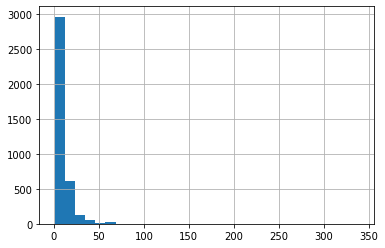

In [17]:
seq_len = [len(i.split()) for i in train_corpus[0]]

pd.Series(seq_len).hist(bins = 30)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_corpus[0],train_corpus['target'], test_size=0.2, random_state=42)
X_train.head()

839          data_size1 = int ( len ( str ( data1 ) ) ) 
644                                     '''<STR_LIT>''' 
1334     return after_y1 , after_y2 , after_p , after_q 
2676                                        plist = [ ] 
3651        y1 , y2 = sorted ( f ( P . x ) for f in L ) 
Name: 0, dtype: object

In [19]:
train_data = tokenize_text(X_train.tolist())
test_data = tokenize_text(X_test.tolist())

In [20]:
train_data

{'input_ids': array([[    0,   414,  1215, ...,     1,     1,     1],
        [    0,   128, 17809, ...,     1,     1,     1],
        [    0,   671,    71, ...,     1,     1,     1],
        ...,
        [    0,   414,   134, ...,     1,     1,     1],
        [    0,  1108,     2, ...,     1,     1,     1],
        [    0,  1948, 32557, ...,  1437,     2,     1]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]])}

In [21]:
inputs = tokenizer("input = stdin . readline", return_tensors="np")
print(inputs)

{'input_ids': array([[    0, 46797,  5457, 49008,   179,   479,  1166,  1902,     2]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [22]:
tokenizer.convert_ids_to_tokens([    0, 46797,  5457, 49008,   179,   479,  1166,  1902,     2])

['<s>', 'input', 'Ġ=', 'Ġstd', 'in', 'Ġ.', 'Ġread', 'line', '</s>']

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('nov18.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [42]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [43]:
model = build_model(bert_layer, max_len=27)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 27)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 27)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 27)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [44]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [24]:
model.fit(
    train_data,
    np.array(y_train),
    validation_data=(
        test_data,
        np.array(y_test)
    ),
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    epochs=10
)

AttributeError: 'RobertaModel' object has no attribute 'fit'

In [26]:
from transformers import TFTrainingArguments, TFTrainer, TFRobertaForSequenceClassification

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained(model_name_code)

trainer = TFTrainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset=test_data             # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/rgoli/software/venv/tf1_gpu/lib/python3.7/site-packages/transformers/trainer_tf.py:114: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/master/examples/tensorflow
  FutureWarning,
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You ca

wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/rgoli/.netrc


AttributeError: 'dict' object has no attribute 'cardinality'

# r_model = TFRobertForSequenceClassification(....)
input_ids = tf.keras.layers.Input([None,], dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input([None,], dtype=tf.int32, name="attention_mask")
token_type_ids = tf.keras.layers.Input([None,], dtype=tf.int32, name="token_type_ids")
output = model([input_ids, attention_mask, token_type_ids])
model = tf.keras.models.Model(inputs=[input_ids, attention_mask, token_type_ids], output=output)

model.compile(....)
model.fit(....)
